In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from collections import Counter

import scipy
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pywt

!pip install antropy
import antropy as ant

!pip install pyrem
import pyrem as pr

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load dataset
The EEG and peripheral physiological signals of 32 participants were recorded as each watched 40 music videos. Participants rated each video in terms of the levels of arousal, valence, dominance, and liking. The data was downsampled (to 128Hz), preprocessed and segmented in pickled Python formats.

In [3]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [4]:
# Load only 22/32 participants with frontal videos recorded
files = []
for n in range(1, 23): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']


Each participant file contains two arrays: a "data" array (40 trials x 40 channels x 8064 data) and a "label" array (40 trials x 4 subjective ratings: valence, arousal, dominance, liking). We combine the data files into 2 new arrays with 880 trials for 22/32 participants (participants with frontal videos recorded).

In [5]:
# 22x40 = 880 trials for 22 participants
labels = []
data = []

for i in files: 
  filename = "/content/drive/MyDrive/data/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])

# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(880, 4)

data = np.array(data)
data = data.flatten()
data = data.reshape(880, 40, 8064)

In [6]:
print(type(labels))

<class 'numpy.ndarray'>


In [7]:
print(np.amax(labels[:,0]))
print(np.amin(labels[:,0]))

9.0
1.0


In [8]:
print(np.amax(labels[:,1]))
print(np.amin(labels[:,1]))

9.0
1.0


In [9]:
print(np.amax(labels[:,2]))
print(np.amin(labels[:,2]))

9.0
1.0


In [10]:
print(np.amax(labels[:,3]))
print(np.amin(labels[:,3]))

9.0
1.0


In [11]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (880, 4)
Data:  (880, 40, 8064)


# Explore and pre-process data

## Labels

#### Get Valence and Arousal ratings
Valence describes the extent to which an emotion is positive or negative, whereas Arousal refers to its intensity, i.e., the strength of the associated emotional state.

In [12]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

          Valence     Arousal
count  880.000000  880.000000
mean     5.218034    5.238898
std      2.093837    1.879631
min      1.000000    1.000000
25%      3.650000    3.895000
50%      5.040000    5.490000
75%      7.040000    6.795000
max      9.000000    9.000000


In [13]:
print(df_label_ratings)

     Valence  Arousal
0       7.71     7.60
1       8.10     7.31
2       8.58     7.54
3       4.94     6.01
4       6.96     3.92
..       ...      ...
875     1.96     7.06
876     1.00     6.05
877     1.00     7.05
878     1.00     7.01
879     2.97     1.96

[880 rows x 2 columns]


In [14]:
df_valence = df_label_ratings.iloc[:,0]
df_valence

0      7.71
1      8.10
2      8.58
3      4.94
4      6.96
       ... 
875    1.96
876    1.00
877    1.00
878    1.00
879    2.97
Name: Valence, Length: 880, dtype: float64

In [15]:
df_arousal = df_label_ratings.iloc[:,1]
df_arousal

0      7.60
1      7.31
2      7.54
3      6.01
4      3.92
       ... 
875    7.06
876    6.05
877    7.05
878    7.01
879    1.96
Name: Arousal, Length: 880, dtype: float64

<Axes: >

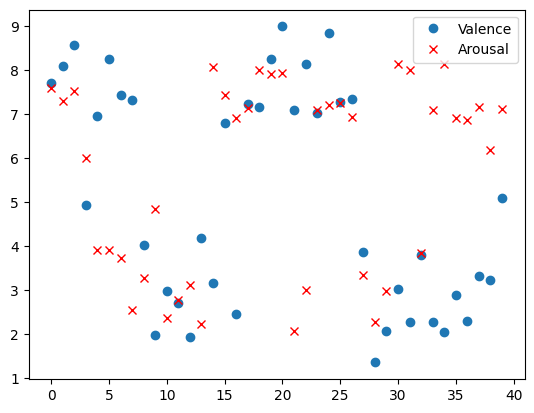

In [16]:
# Plot the first 40 data rows (first participant)
df_label_ratings.iloc[0:40].plot(style=['o','rx'])

#### Check positive/negative cases

The combinations of Valence and Arousal can be converted to emotional states: High Arousal Positive Valence (Excited, Happy), Low Arousal Positive Valence (Calm, Relaxed), High Arousal Negative Valence (Angry, Nervous), and Low Arousal Negative Valence (Sad, Bored).

In [17]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [18]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 457
Negative Valence: 423
High Arousal: 442
Low Arousal: 438


In [19]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 242
Low Arousal Positive Valence: 215
High Arousal Negative Valence: 200
Low Arousal Negative Valence: 223


In [20]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.12 STD 1.04
Arousal: Mean 6.81 STD 0.84

LAHV:
Valence: Mean 6.67 STD 1.09
Arousal: Mean 3.87 STD 1.09

HALV:
Valence: Mean 3.19 STD 1.23
Arousal: Mean 6.79 STD 0.96

LALV:
Valence: Mean 3.57 STD 1.12
Arousal: Mean 3.47 STD 1.19


{'whiskers': [<matplotlib.lines.Line2D at 0x7f29ee53a2e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f29ee53a820>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f29ee53a040>,
 'medians': [<matplotlib.lines.Line2D at 0x7f29ee53ad60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f29ee549040>,
 'means': []}

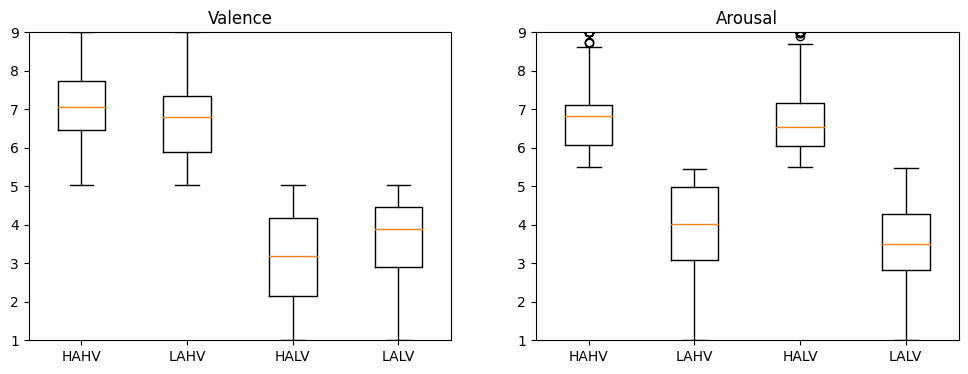

In [21]:
# Valence and Arousal ratings between groups
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['Valence'], df_lahv['Valence'], df_halv['Valence'], df_lalv['Valence']], labels=['HAHV','LAHV','HALV', 'LALV'])

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['Arousal'], df_lahv['Arousal'], df_halv['Arousal'], df_lalv['Arousal']], labels=['HAHV','LAHV','HALV', 'LALV'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f29ee342430>,
 'caps': [<matplotlib.lines.Line2D at 0x7f29ee3429d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f29ee342190>,
 'medians': [<matplotlib.lines.Line2D at 0x7f29ee342f10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f29ee34c1f0>,
 'means': []}

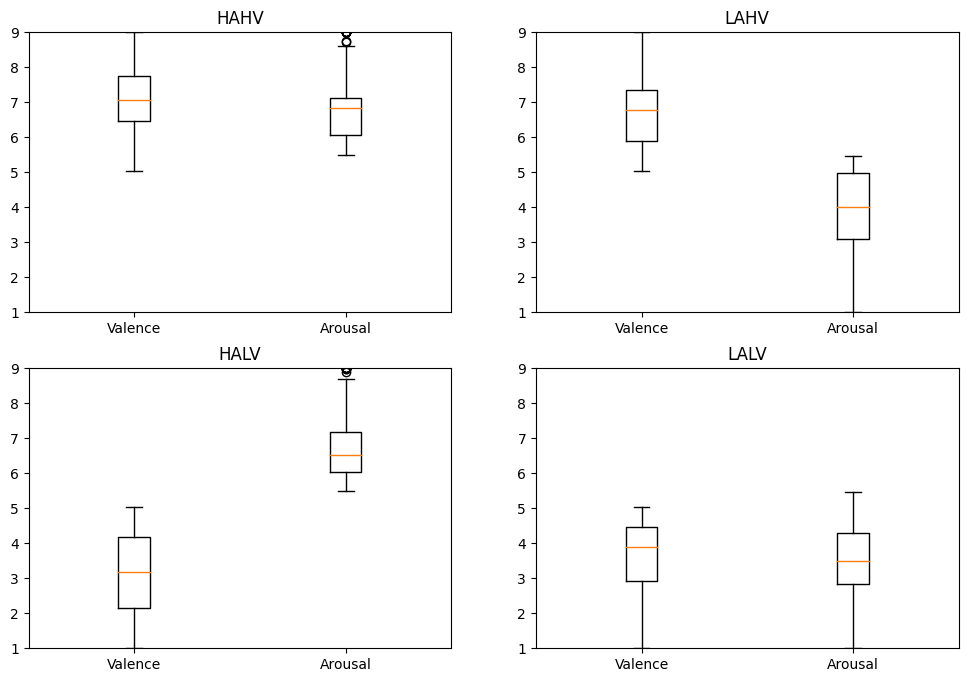

In [22]:
# Valence and Arousal ratings per group
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].set_title("HAHV")
axs[0,0].set_ylim(1, 9)
axs[0,0].boxplot([df_hahv['Valence'], df_hahv['Arousal']], labels=['Valence','Arousal'])

axs[0,1].set_title("LAHV")
axs[0,1].set_ylim(1, 9)
axs[0,1].boxplot([df_lahv['Valence'], df_lahv['Arousal']], labels=['Valence','Arousal'])

axs[1,0].set_title("HALV")
axs[1,0].set_ylim(1, 9)
axs[1,0].boxplot([df_halv['Valence'], df_halv['Arousal']], labels=['Valence','Arousal'])

axs[1,1].set_title("LALV")
axs[1,1].set_ylim(1, 9)
axs[1,1].boxplot([df_lalv['Valence'], df_lalv['Arousal']], labels=['Valence','Arousal'])

## EEG data

### Separate EEG and non-EEG data

The dataset includes 32 EEG channels and 8 peripheral physiological channels. The peripheral signals include: electrooculogram (EOG), electromyograms (EMG) of Zygomaticus and Trapezius muscles, GSR, respiration amplitude, blood volume by plethysmograph, skin temperature.

In [23]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [24]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(880, 32, 8064)


In [25]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(880, 8, 8064)


### Welch's feature extraction

For the EEG data, we use Welch's method to extract theta, alpha, beta, and gamma spectral
power for each electrode. The frequency bands used:
theta (4 - 8 Hz), alpha (8 - 12 Hz), beta (12 - 30 Hz),
and gamma (30 - 64 Hz).

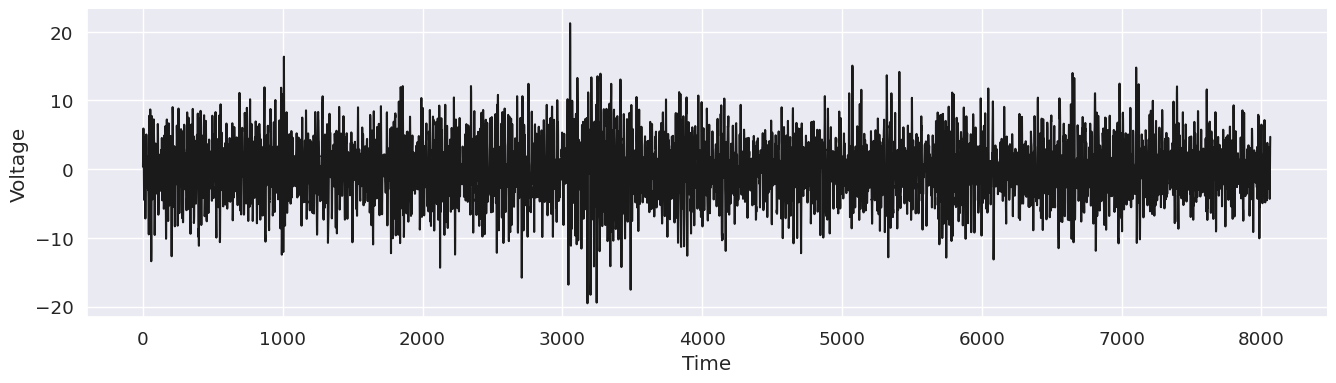

In [26]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()

<class 'numpy.ndarray'>


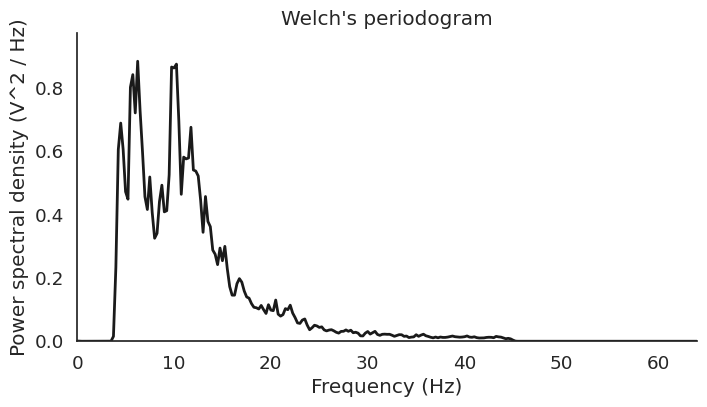

In [27]:
# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(eeg_data[0,31], sf, nperseg=win, scaling="spectrum")
print(type(psd))

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

#### Theta band power

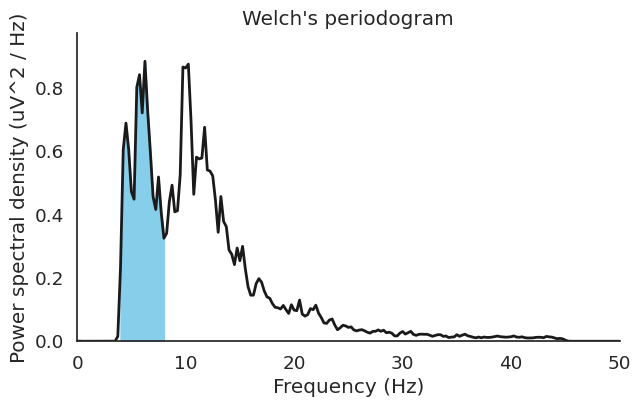

In [28]:
# Define theta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_theta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the theta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_theta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Alpha band power

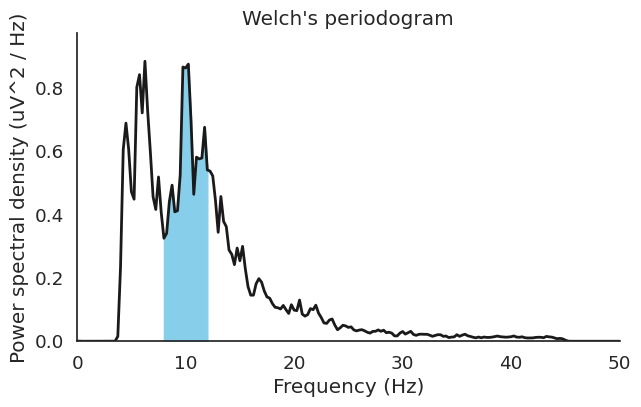

In [29]:
# Define alpha lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_alpha = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the alpha area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_alpha, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Beta band power

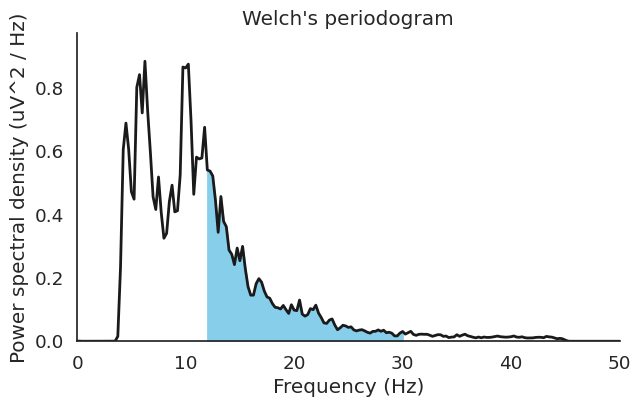

In [30]:
# Define beta lower and upper limits
low, high = 12, 30

# Find intersecting values in frequency vector
idx_beta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the beta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_beta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Gamma band power

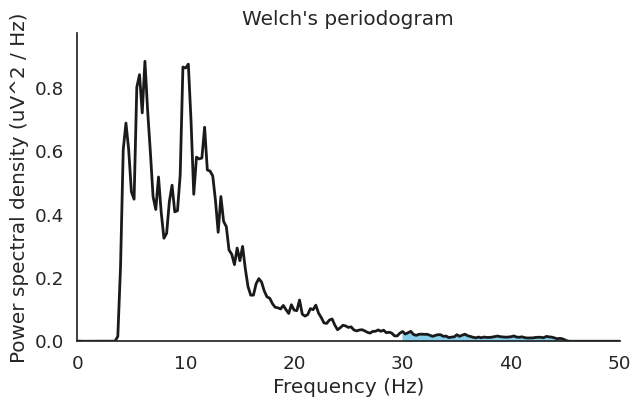

In [31]:
# Define delta lower and upper limits
low, high = 30, 64

# Find intersecting values in frequency vector
idx_gamma = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the gamma area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_gamma, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 50])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

#### Functions to get band power values

In [32]:
"""Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [33]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)
  
  return bandpower(eeg_data[trial,channel], 128, bd)

print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295193
6.286556266834863
0.9879159580139809


### Hjorth Parameters

In [34]:
morbility, complexity = ant.hjorth_params(eeg_data[0,31])

In [35]:
print(morbility)
print(complexity)

0.6352277913193156
1.5674002408306014


### Discrete Wavelet Transform

In [36]:
def calc_wavelet_energy(data_set):
  """
    Input : 1 * N vector
    Output: Float with the wavelet energy of the input vector,
    rounded to 3 decimal places.
  """
  # p_sqr = [i ** 2 for i in data_set]
  wavelet_energy = np.nansum(np.log2(np.square(data_set)))
  return round(wavelet_energy, 3)

In [37]:
def calc_shannon_entropy(data_set):
  """
    Input : 1 * N vector
    Output: Float with the wavelet entropy of the input vector,
    rounded to 3 decimal places.
  """
  # probability = [i ** 2 for i in data_set]
  probability = np.square(data_set)
  shannon_entropy = -np.nansum(probability * np.log2(probability))
  return round(shannon_entropy, 3)

In [38]:
eeg_data.shape

(880, 32, 8064)

In [39]:
coeffs = pywt.wavedec(eeg_data, 'db4', level=4)
cA4, cD4, cD3, cD2, cD1 = coeffs

In [40]:
cD1.shape

(880, 32, 4035)

### Create EEG plots

#### General plots

In [41]:
info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [42]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [43]:
raw_data = mne.io.RawArray(eeg_data[31], info)

Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


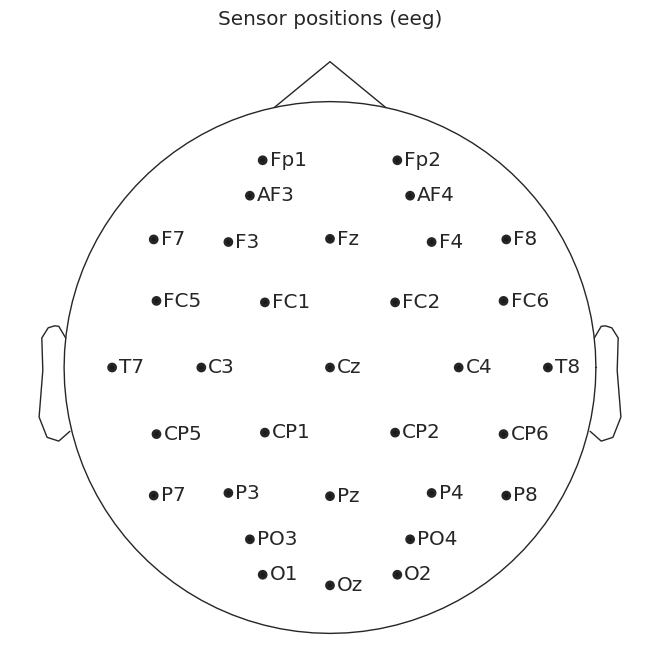

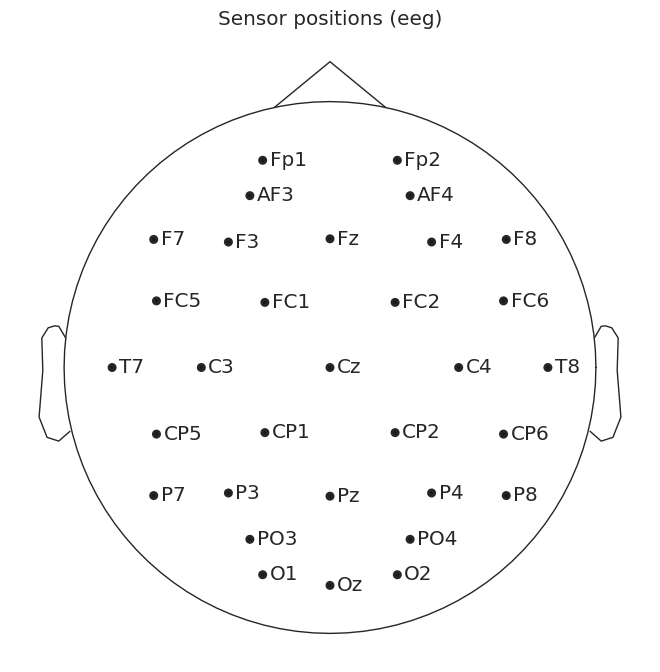

In [44]:
# Plot sensor positions
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()

In [45]:
# Plot the power spectral density across channels
mne.viz.plot_raw_psd(raw_data, fmin = 4, fmax= 45)

#### Topomaps for each band of frequencies

Following this thread: https://mail.nmr.mgh.harvard.edu/pipermail//mne_analysis/2019-April/005812.html

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarn

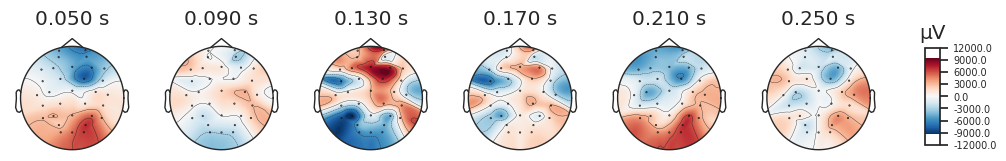

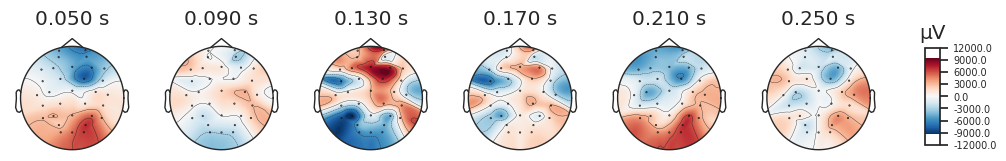

In [46]:
# Theta band, first trial
evData_th = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_th.filter(4, 8) 
evData_th.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarn

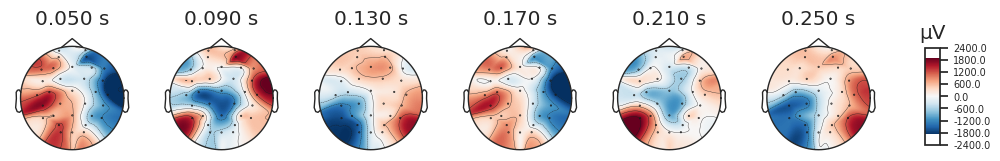

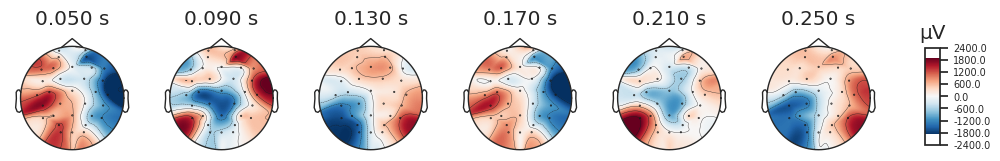

In [47]:
# Alpha band, first trial
evData_al = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_al.filter(8, 12) 
evData_al.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarn

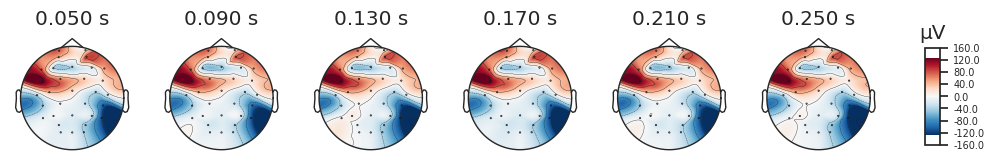

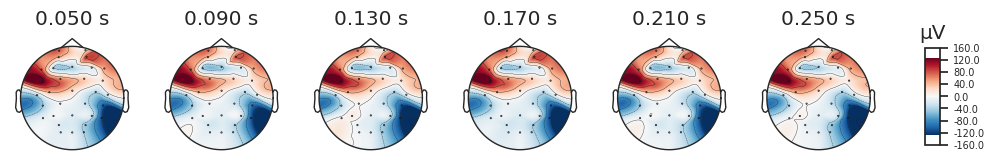

In [48]:
# Beta band, first trial
evData_bt = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_bt.filter(12, 30) 
evData_bt.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarn

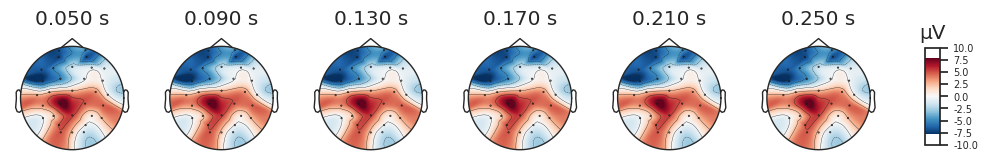

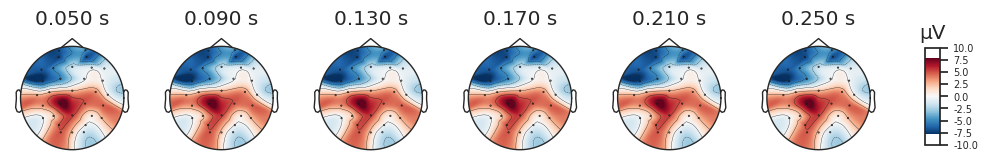

In [49]:
# Gamma band, first trial
evData_gm = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_gm.filter(30, 63.9) 
evData_gm.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

#### Topomaps of subjects from HAHV - HALV - LAHV - LALV groups

In [50]:
# Getting samples from 4 label groups, same subject
ev_data_hahv = mne.EvokedArray(eeg_data[1], info)
ev_data_halv = mne.EvokedArray(eeg_data[14], info)
ev_data_lahv = mne.EvokedArray(eeg_data[6], info)
ev_data_lalv = mne.EvokedArray(eeg_data[9], info)

In [51]:
# Plot the topographies across different frequency bands
def plot_topo_psd(evData):
  evData.filter(4, 8) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(8, 12) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(12, 30) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(30, 63.9) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


AttributeError: ignored

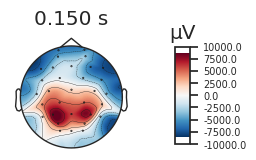

In [52]:
plot_topo_psd(ev_data_hahv)

In [ ]:
plot_topo_psd(ev_data_halv)

In [ ]:
plot_topo_psd(ev_data_lahv)

In [ ]:
plot_topo_psd(ev_data_lalv)

#### Topomaps of subjects from HAHV - HALV - LAHV - LALV groups by FOOOF

This will help plotting topomaps of all bands with the same scale of power spectra.

In [91]:
# Deal with NaN values when the model cannot detect peaks in any given range
def check_nans(data, nan_policy='zero'):
    """Check an array for nan values, and replace, based on policy."""
    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))
    # Apply desired nan policy to data
    if nan_policy == 'zero':
        data[nan_inds] = 0
    elif nan_policy == 'mean':
        data[nan_inds] = np.nanmean(data)
    else:
        raise ValueError('Nan policy not understood.')
    return data

In [92]:
# Plot the topographies across different frequency bands
def plot_psd_fooof(evData):
  fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
  bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
  freq_range = [1, 128]
  # Calculate power spectra across the the continuous data by MNE
  spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
  fg.fit(freqs, spectra, freq_range)
  # Plot the topographies across different frequency bands
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))
  for ind, (label, band_def) in enumerate(bands):
      # Extract the power peaks across channels for the current band
      band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
      # Create a topomap for the current oscillation band
      mne.viz.plot_topomap(band_power, evData.info, cmap=cm.viridis, axes=axes[ind], show=False);
      axes[ind].set_title(label + ' power', {'fontsize' : 16})

In [93]:
def plot_psd_peak(evData):
  fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
  bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
  freq_range = [1, 128]
  # Calculate power spectra across the continuous data by MNE
  spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
  fg.fit(freqs, spectra, freq_range)
  # Check the largest detected peaks within each band
  fig, axes = plt.subplots(1, 4, figsize=(20, 6))
  for ind, (label, band_def) in enumerate(bands):
      # Get the power values across channels for the current band
      band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
      # Extracted and plot the power spectrum model with the most band power
      fg.get_fooof(np.argmax(band_power)).plot(ax=axes[ind], add_legend=True)
      axes[ind].yaxis.set_ticklabels([])
      axes[ind].set_title('biggest ' + label + ' peak', {'fontsize' : 16})

Effective window size : 2.344 (s)


/usr/local/lib/python3.9/dist-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(da

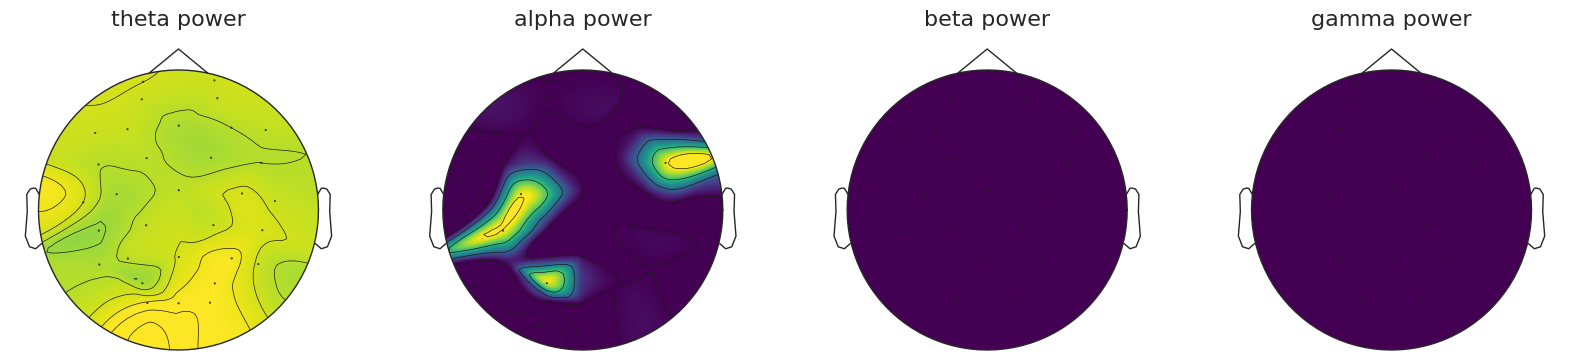

In [94]:
plot_psd_fooof(ev_data_hahv)

Effective window size : 2.344 (s)


/usr/local/lib/python3.9/dist-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


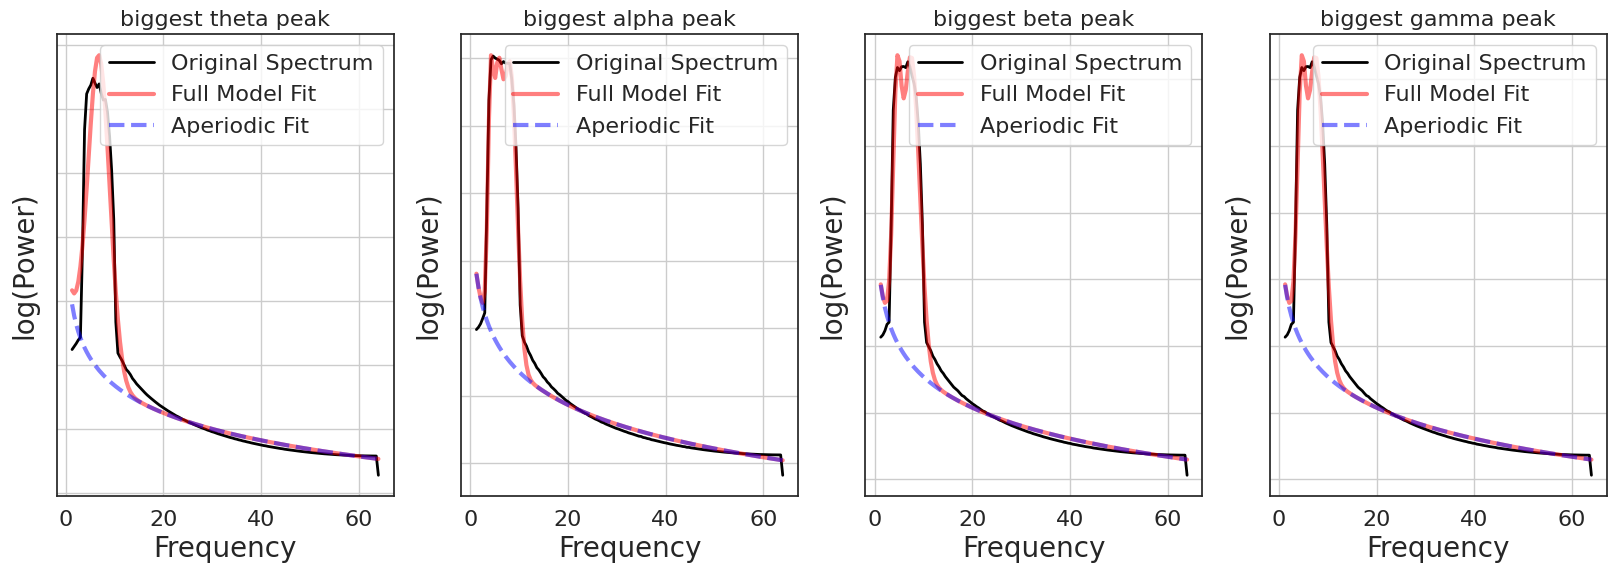

In [95]:
plot_psd_peak(ev_data_hahv)

Effective window size : 2.344 (s)


/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


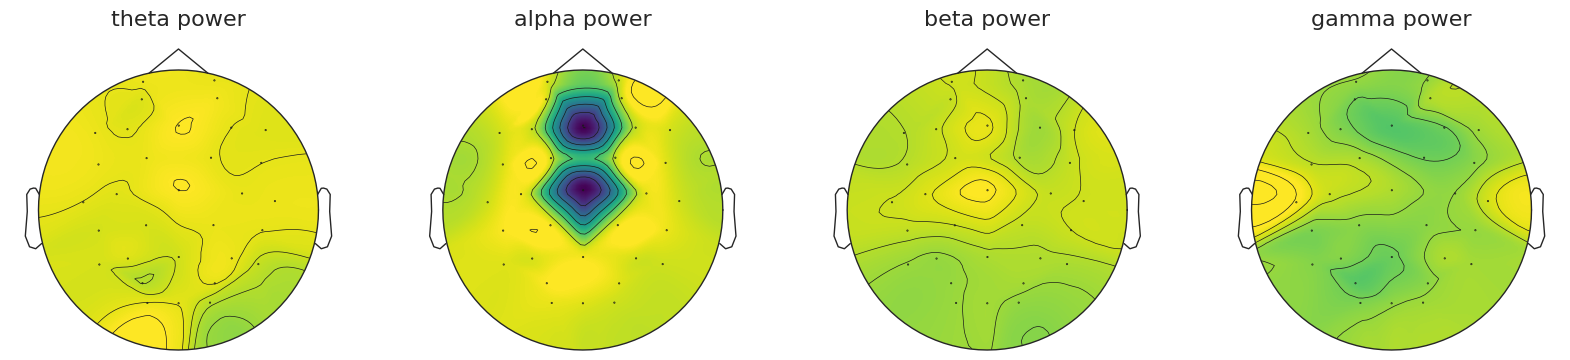

In [96]:
plot_psd_fooof(ev_data_halv)

Effective window size : 2.344 (s)


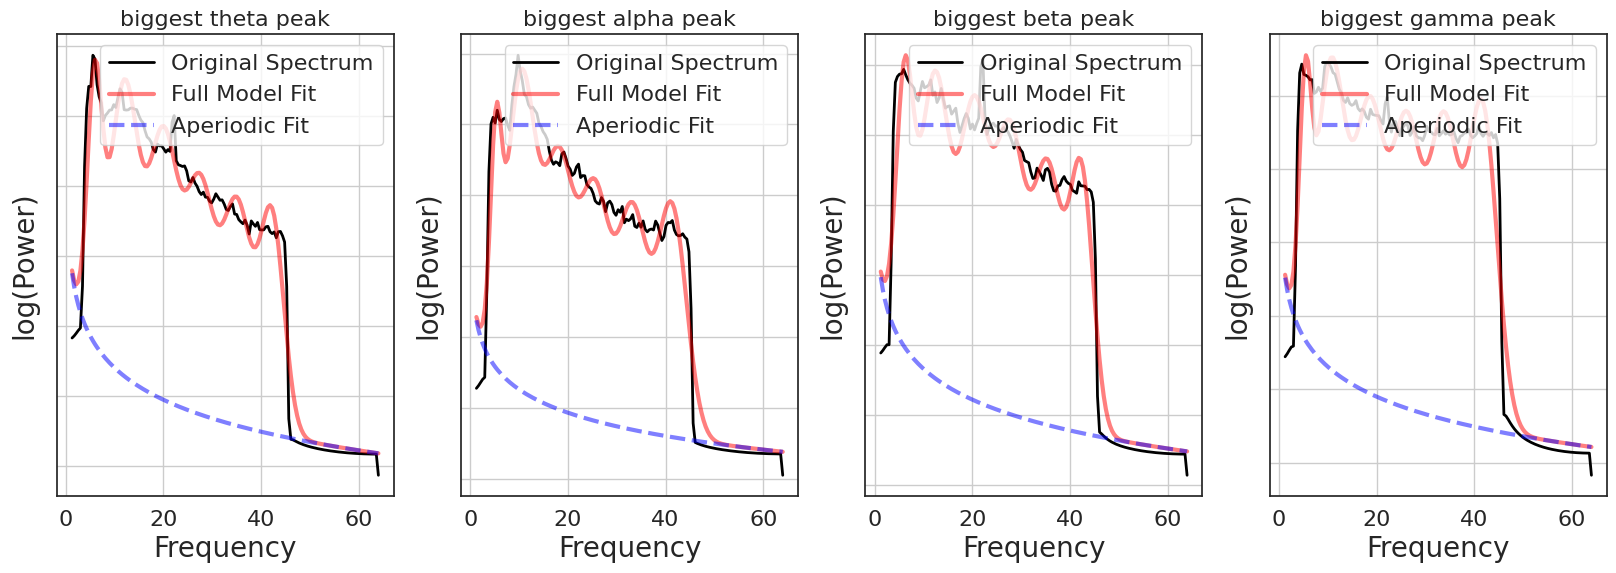

In [97]:
plot_psd_peak(ev_data_halv)

Effective window size : 2.344 (s)


/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


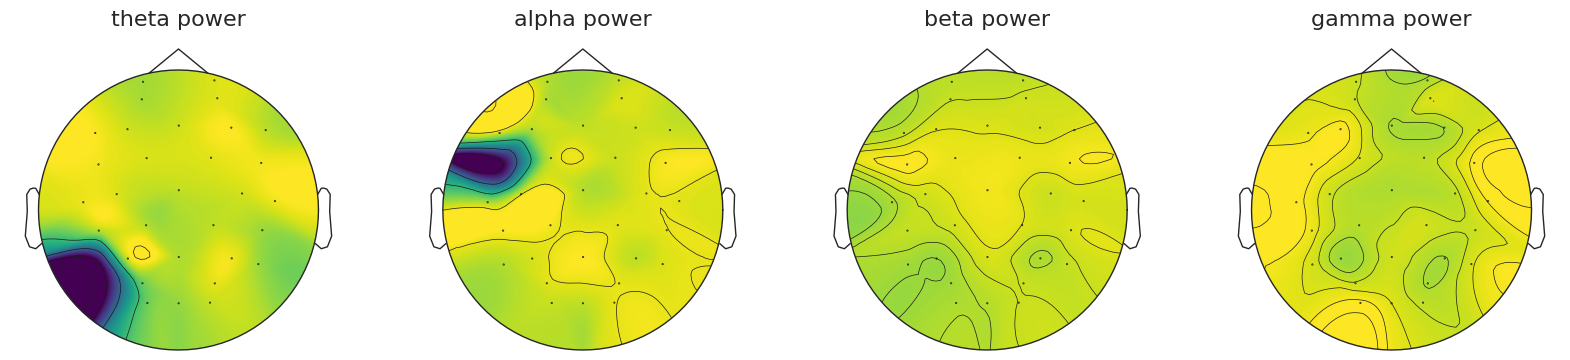

In [98]:
plot_psd_fooof(ev_data_lahv)

Effective window size : 2.344 (s)


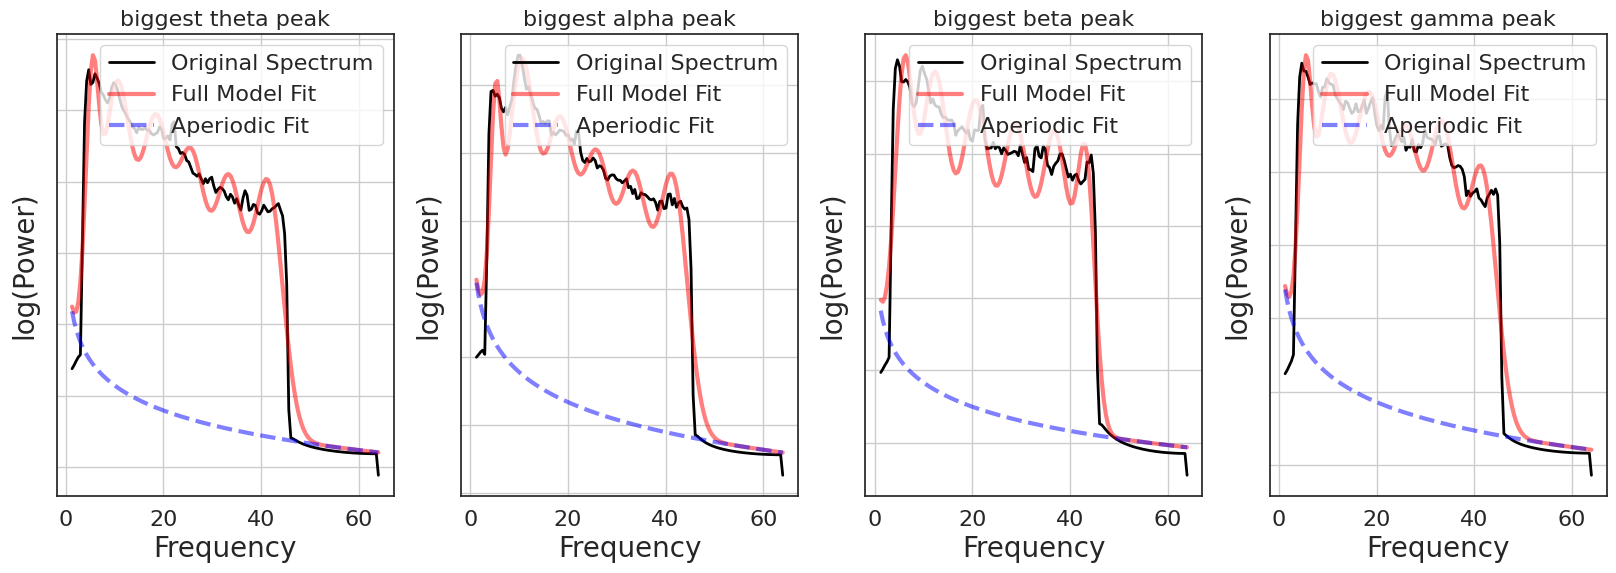

In [99]:
plot_psd_peak(ev_data_lahv)

Effective window size : 2.344 (s)


/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.9/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


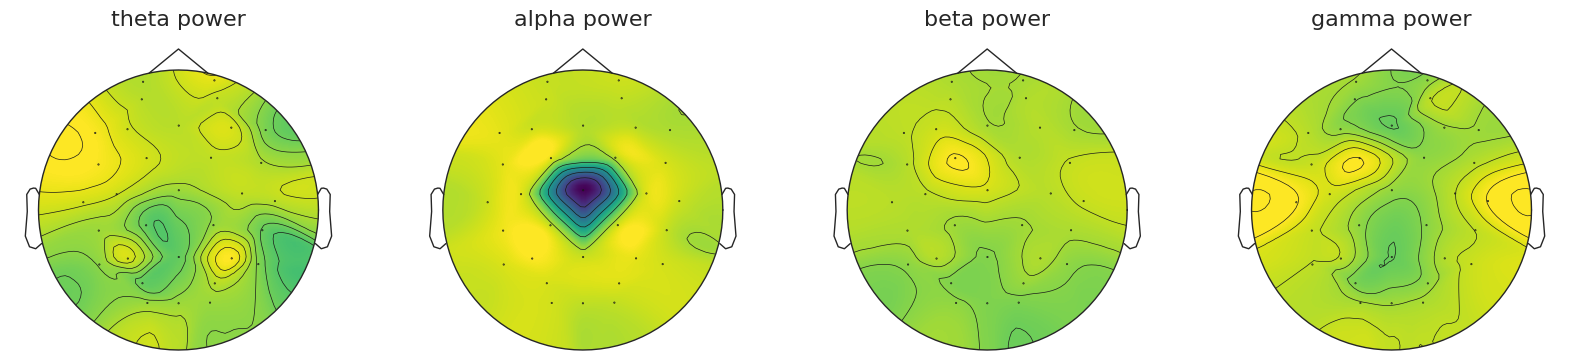

In [100]:
plot_psd_fooof(ev_data_lalv)

Effective window size : 2.344 (s)


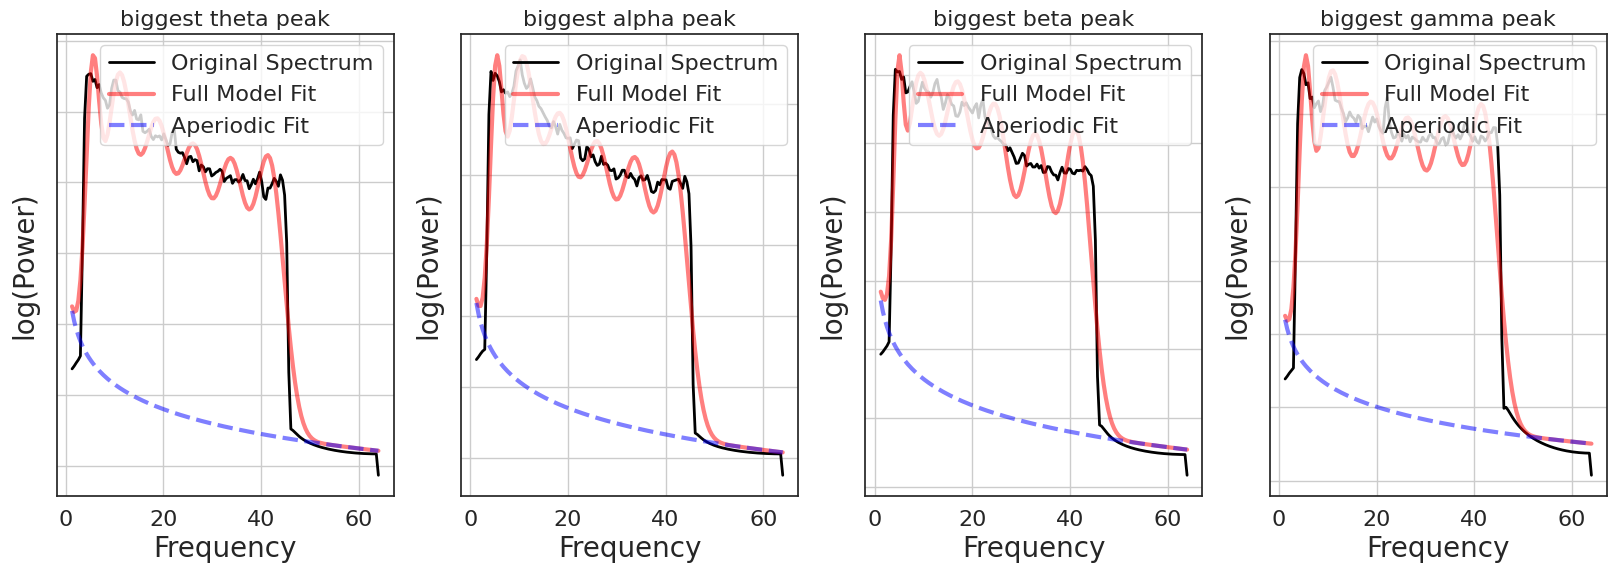

In [101]:
plot_psd_peak(ev_data_lalv)

### Process new datasets with 6 EEG regions and 4 band power values

In [53]:
# Transform 880 x 32 x 8064 => 880 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
eeg_band_arr = np.reshape(eeg_band_arr, (880, 128))

In [54]:
eeg_band_arr.shape

(880, 128)

EEG channels are divided into 6 groups, according to their cerebral spatial locations. We combine the temmporal-left and temporal-right channels into the left and right groups. The frontal group only includes the fronto-central channels. All centro-parietal channels are included in the central group.

In [55]:
left = np.array(["Fp1", "AF3", "F7", "FC5", "T7"])
right = np.array(["Fp2", "AF4", "F8", "FC6", "T8"])
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])
all = np.array(["Fp1", "AF3", "F7", "FC5", "T7", "Fp2", "AF4", "F8", "FC6", "T8", "F3", "FC1", "Fz", "F4", "FC2", "P3", "P7", "Pz", "P4", "P8", "O1", "Oz", "O2", "PO3", "PO4", "CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

#### Dataframe for Theta power values

In [56]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (880, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   5.476950e+02  1.275378e+03  9.614671e+02  2.081234e+03  9.465403e+02   
std    1.217591e+03  3.736183e+03  3.558846e+03  5.918704e+03  2.572976e+03   
min    6.907710e-12  5.217485e-12  8.531922e-12  1.108519e-11  7.519470e-12   
25%    2.409321e+01  1.860138e+01  2.204631e+01  3.912328e+01  1.387218e+01   
50%    5.845061e+01  7.275575e+01  7.399130e+01  1.053462e+02  4.300044e+01   
75%    3.662748e+02  3.134779e+02  1.963466e+02  2.787570e+02  2.560120e+02   
max    1.552414e+04  3.812287e+04  3.943132e+04  4.927279e+04  2.018267e+04   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   3.356565e+02  6.296856e+02  3.841770e+02  4.374693e+02  2.786742e+02   
std    7.140848e+02  1.774587e+03  6.900458e+02  1.

In [57]:
# Only print central channels
print(df_theta[central].head(5)) 

            CP5           CP1            Cz            C4            C3  \
0  2.881030e-12  1.102969e-11  7.516943e-12  2.045050e-12  4.197735e-12   
1  3.229423e+00  1.965246e+00  2.452893e+00  3.689678e+00  4.325760e+00   
2  3.711943e+00  1.890259e+00  2.386166e+00  3.942938e+00  4.284358e+00   
3  4.004765e+00  1.883543e+00  7.414694e+00  3.498076e+00  4.171965e+00   
4  1.857737e+00  1.447578e+00  1.993286e+00  1.803010e+00  1.798486e+00   

            CP6           CP2  
0  3.026707e-12  3.933774e-12  
1  1.909712e+00  1.942158e+00  
2  2.503685e+00  1.974655e+00  
3  2.529543e+00  1.736048e+00  
4  1.496299e+00  1.577524e+00  


#### Dataframe for Alpha power values

In [58]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_alpha = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_alpha.append(get_band_power(i,j,"alpha"))
eeg_alpha = np.reshape(eeg_alpha, (880, 32))

df_alpha = pd.DataFrame(data = eeg_alpha, columns=eeg_channels)
print(df_alpha.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.827742e+02  4.330030e+02  3.417225e+02  7.873920e+02  3.147338e+02   
std    3.976123e+02  1.257595e+03  1.216975e+03  2.308047e+03  8.258109e+02   
min    2.933705e-11  2.410982e-11  4.107240e-11  4.240856e-11  3.524506e-11   
25%    1.419147e+01  1.160664e+01  1.198029e+01  2.027352e+01  1.002601e+01   
50%    3.325528e+01  3.057807e+01  3.480832e+01  4.343559e+01  1.869576e+01   
75%    1.431223e+02  1.132199e+02  7.668653e+01  9.853214e+01  8.089379e+01   
max    5.627907e+03  1.238070e+04  1.276472e+04  2.084307e+04  6.575781e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.212759e+02  2.177939e+02  1.345652e+02  1.526717e+02  9.739679e+01   
std    2.395003e+02  5.892200e+02  2.122968e+02  4.

In [59]:
# Only print occipital channels
print(df_alpha[occipital].head(5)) 

             O1            Oz            O2           PO3           PO4
0  1.958276e-11  1.063586e-11  1.475856e-11  2.995791e-11  2.110533e-11
1  2.037402e+00  2.195514e+00  2.565861e+00  1.703727e+00  3.038914e+00
2  6.263437e+00  5.958844e+00  8.209320e+00  7.656804e+00  9.179372e+00
3  5.632504e+00  5.341003e+00  6.541218e+00  6.627711e+00  6.922430e+00
4  4.457119e+00  4.057350e+00  5.195625e+00  5.767454e+00  5.225959e+00


#### Dataframe for Beta power values

In [60]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_beta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_beta.append(get_band_power(i,j,"beta"))
eeg_beta = np.reshape(eeg_beta, (880, 32))

df_beta = pd.DataFrame(data = eeg_beta, columns=eeg_channels)
print(df_beta.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   1.015978e+02  2.639376e+02  2.354919e+02  4.653838e+02  1.797817e+02   
std    1.983413e+02  7.963972e+02  7.883722e+02  1.519026e+03  4.581536e+02   
min    6.467192e-09  9.313548e-09  1.064947e-08  7.639419e-09  9.420482e-09   
25%    1.808682e+01  1.198300e+01  1.072901e+01  2.209180e+01  1.120456e+01   
50%    3.472251e+01  2.512552e+01  3.628217e+01  3.828849e+01  2.447575e+01   
75%    8.583555e+01  1.269000e+02  6.071346e+01  6.669544e+01  5.144377e+01   
max    3.528485e+03  5.784160e+03  5.841476e+03  1.484870e+04  3.094688e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   7.906016e+01  1.223933e+02  8.833881e+01  1.005311e+02  5.610935e+01   
std    1.430114e+02  2.926317e+02  9.901186e+01  3.

In [61]:
# Only print frontal channels
print(df_beta[frontal].head(5)) 

             F3           FC1            Fz            F4           FC2
0  1.064947e-08  5.310574e-09  2.966548e-09  1.301296e-09  1.937739e-09
1  5.601125e-01  3.139066e-01  5.843029e-01  6.888838e-01  5.163545e-01
2  9.839357e+00  4.390210e+00  7.598063e+00  9.444911e+00  6.377253e+00
3  7.032711e+00  3.946574e+00  6.481246e+00  6.763315e+00  5.341841e+00
4  6.021147e+00  3.145262e+00  5.356596e+00  5.797735e+00  4.608033e+00


#### Dataframe for Gamma power values

In [62]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_gamma = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_gamma.append(get_band_power(i,j,"gamma"))
eeg_gamma = np.reshape(eeg_gamma, (880, 32))

df_gamma = pd.DataFrame(data = eeg_gamma, columns=eeg_channels)
print(df_gamma.describe())

                Fp1           AF3            F3            F7           FC5  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   6.435773e+01  2.097042e+02  1.946063e+02  1.599363e+02  1.241945e+02   
std    1.612175e+02  7.714500e+02  7.533755e+02  5.928322e+02  4.063999e+02   
min    7.946773e-08  8.261575e-08  1.469369e-07  1.553065e-07  1.285862e-07   
25%    9.012946e+00  5.500269e+00  5.077370e+00  1.119272e+01  5.261965e+00   
50%    2.067978e+01  1.455904e+01  1.540315e+01  1.849035e+01  1.354138e+01   
75%    4.835953e+01  7.474244e+01  3.809379e+01  4.398563e+01  4.454889e+01   
max    3.213256e+03  6.060540e+03  5.758757e+03  6.348177e+03  3.472516e+03   

                FC1            C3            T7           CP5           CP1  \
count  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02  8.800000e+02   
mean   5.618785e+01  7.456877e+01  5.328883e+01  8.053081e+01  3.272422e+01   
std    1.412318e+02  2.143440e+02  7.123975e+01  2.

In [63]:
# Only print parietal channels
print(df_gamma[parietal].head(5))

             P3            P7            Pz            P4            P8
0  1.807680e-08  1.430477e-08  4.173796e-08  6.907498e-08  6.513504e-08
1  3.758846e-02  2.726338e-02  1.336297e-02  4.865600e-02  1.691512e-02
2  1.405996e+00  2.340776e+00  6.149348e-01  1.759804e+00  1.651851e+00
3  1.127093e+00  1.381447e+00  5.556367e-01  1.406085e+00  8.040019e-01
4  1.031171e+00  1.626731e+00  5.353514e-01  1.275852e+00  1.514359e+00


#### Dataframe of Wavelet Energy

In [64]:
#Calculate the wavelet energy

we_theta = []

for i in range (len(cD4)):
  for j in range (len(cD4[0])):
    we_theta.append(calc_wavelet_energy(cD4[i,j]))
we_theta = np.reshape(we_theta, (880, 32))
df_we_theta = pd.DataFrame(data = we_theta, columns=eeg_channels)

we_alpha = []
for i in range (len(cD3)):
  for j in range (len(cD3[0])):
    we_alpha.append(calc_wavelet_energy(cD3[i,j]))
we_alpha = np.reshape(we_alpha, (880, 32))
df_we_alpha = pd.DataFrame(data = we_alpha, columns=eeg_channels)

we_beta = []
for i in range (len(cD2)):
  for j in range (len(cD2[0])):
    we_beta.append(calc_wavelet_energy(cD2[i,j]))
we_beta = np.reshape(we_beta, (880, 32))
df_we_beta = pd.DataFrame(data = we_beta, columns=eeg_channels)

we_gamma = []
for i in range (len(cD1)):
  for j in range (len(cD1[0])):
    we_gamma.append(calc_wavelet_energy(cD1[i,j]))
we_gamma = np.reshape(we_gamma, (880, 32))
df_we_gamma = pd.DataFrame(data = we_gamma, columns=eeg_channels)

df_we_theta.describe()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2
count,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,...,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,3797.911584,3863.705559,3730.253145,4088.053127,3534.249236,3599.168620,3619.558264,4001.612801,3436.004378,3497.027380,...,3827.062376,3763.272970,3179.461590,3864.089377,3667.221256,3640.801635,3757.402891,3565.856422,3852.652969,3585.853390
std,1027.710358,1217.045253,1120.663632,1364.467390,1275.343322,1013.461937,1086.034398,905.855657,1051.484812,1035.609962,...,1159.181687,1134.025196,1158.202462,1165.936166,1204.361567,1086.868790,1021.074147,988.610394,1106.501915,971.813779
min,1744.368000,1859.358000,1863.687000,1987.878000,1622.452000,1533.148000,1607.253000,2038.366000,1617.200000,1270.604000,...,1863.158000,1323.099000,1446.932000,1651.530000,1314.070000,1306.055000,1975.444000,1689.199000,2013.068000,2017.006000
25%,3096.766500,2848.755000,2840.887750,3231.623500,2649.038250,2774.162000,2912.695500,3236.377250,2698.042000,2865.865000,...,2870.660500,3113.491250,2470.226000,3157.094500,2874.942500,2942.638000,2983.645750,2902.545250,3088.112750,2873.336250
50%,3666.074500,3606.443500,3717.745500,3804.131500,3212.415000,3480.933000,3383.066500,3966.097500,3199.127500,3272.712500,...,3631.404000,3584.879500,2893.432500,3648.088000,3707.785500,3507.610500,3534.894500,3528.654500,3514.123000,3429.562000
75%,4409.450500,4596.564750,4271.223000,4377.039750,3877.702250,4348.483500,4178.400750,4635.204000,3933.720000,4261.777500,...,4426.494250,4432.443250,3575.228000,4493.525250,4299.504750,4378.872250,4336.410500,4214.167750,4407.543000,3948.804250
max,7420.727000,7683.368000,7705.545000,8285.644000,7626.942000,6805.992000,7633.307000,6682.734000,6966.436000,6719.926000,...,7130.373000,7464.051000,7749.208000,7480.742000,7589.593000,6522.741000,7092.208000,6648.104000,7113.298000,6927.284000


In [65]:
# Only print central channels
print(df_we_theta[central].head(5))

        CP5       CP1        Cz        C4        C3       CP6       CP2
0  1749.426  1270.604  1584.091  1599.946  1891.242  1414.519  1314.317
1  1979.581  1551.048  1580.935  1922.284  1966.003  1553.912  1567.221
2  2018.557  1492.501  1610.649  1813.684  1876.648  1633.485  1605.560
3  1995.150  1545.803  1829.836  1664.026  1897.061  1573.207  1439.850
4  1629.365  1441.315  1477.718  1565.080  1607.253  1480.223  1421.084


#### Dataframe of Shannon Entropy

In [66]:
#Calculate the Shannon Entropy

en_theta = []
for i in range (len(cD4)):
  for j in range (len(cD4[0])):
    en_theta.append(calc_shannon_entropy(cD4[i,j]))
en_theta = np.reshape(en_theta, (880, 32))
df_en_theta = pd.DataFrame(data = en_theta, columns=eeg_channels)

en_alpha = []
for i in range (len(cD3)):
  for j in range (len(cD3[0])):
    en_alpha.append(calc_shannon_entropy(cD3[i,j]))
en_alpha = np.reshape(en_alpha, (880, 32))
df_en_alpha = pd.DataFrame(data = en_alpha, columns=eeg_channels)

en_beta = []
for i in range (len(cD2)):
  for j in range (len(cD2[0])):
    en_beta.append(calc_shannon_entropy(cD2[i,j]))
en_beta = np.reshape(en_beta, (880, 32))
df_en_beta = pd.DataFrame(data = en_beta, columns=eeg_channels)

en_gamma = []
for i in range (len(cD1)):
  for j in range (len(cD1[0])):
    en_gamma.append(calc_shannon_entropy(cD1[i,j]))
en_gamma = np.reshape(en_gamma, (880, 32))
df_en_gamma = pd.DataFrame(data = en_gamma, columns=eeg_channels)

df_en_theta.describe()

,Fp1,AF3,F3,F7,FC5,FC1,C3,T7,CP5,CP1,...,FC2,Cz,C4,T8,CP6,CP2,P4,P8,PO4,O2
count,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,...,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02,8.800000e+02
mean,-7.834042e+07,-2.053084e+08,-1.574202e+08,-3.302743e+08,-1.454915e+08,-4.569135e+07,-9.398031e+07,-5.044453e+07,-6.432993e+07,-3.656448e+07,...,-1.022536e+08,-7.305353e+07,-8.548086e+07,-1.469489e+08,-8.260733e+07,-5.123086e+07,-9.264899e+07,-2.796249e+07,-1.215833e+08,-6.479923e+07
std,1.899166e+08,6.392340e+08,6.195550e+08,9.678205e+08,4.119928e+08,1.088531e+08,2.921849e+08,1.004553e+08,2.149173e+08,7.467268e+07,...,2.888478e+08,2.277250e+08,3.513396e+08,4.447923e+08,2.778779e+08,1.146901e+08,2.681585e+08,6.986562e+07,3.100286e+08,2.014142e+08
min,-2.690421e+09,-6.489032e+09,-6.733023e+09,-7.966558e+09,-3.284026e+09,-1.430999e+09,-4.729141e+09,-1.029363e+09,-2.340571e+09,-9.634121e+08,...,-3.016240e+09,-2.461315e+09,-3.830047e+09,-4.698740e+09,-3.025304e+09,-1.086225e+09,-2.840943e+09,-7.572886e+08,-2.769966e+09,-1.941416e+09
25%,-4.610219e+07,-3.790153e+07,-2.221209e+07,-3.268827e+07,-3.173921e+07,-3.561615e+07,-3.256846e+07,-4.914283e+07,-2.428534e+07,-2.794352e+07,...,-2.703768e+07,-3.978924e+07,-1.499726e+07,-5.700113e+07,-3.115916e+07,-3.638169e+07,-3.289150e+07,-2.415569e+07,-5.771332e+07,-1.534640e+07
50%,-5.636806e+06,-7.241212e+06,-7.279362e+06,-1.121053e+07,-4.093456e+06,-6.646893e+06,-5.561258e+06,-1.408315e+07,-4.806761e+06,-5.069616e+06,...,-8.564076e+06,-7.987607e+06,-2.359509e+06,-9.581095e+06,-9.669064e+06,-7.505361e+06,-8.026858e+06,-7.966119e+06,-6.684854e+06,-5.624715e+06
75%,-2.007931e+06,-1.440993e+06,-1.889279e+06,-3.566276e+06,-1.043975e+06,-1.098622e+06,-2.247842e+06,-5.452159e+06,-1.503647e+06,-2.567815e+06,...,-3.382109e+06,-2.675060e+06,-8.210834e+05,-2.089790e+06,-2.186219e+06,-1.987077e+06,-2.284822e+06,-1.582073e+06,-2.448376e+06,-1.425070e+06
max,-1.476856e+05,-1.671220e+05,-1.773304e+05,-2.257046e+05,-1.052627e+05,-9.604451e+04,-8.692388e+04,-2.295869e+05,-9.873342e+04,-7.144315e+04,...,-1.849542e+05,-8.918443e+04,-8.460078e+04,-1.052614e+05,-7.359102e+04,-7.195321e+04,-2.225745e+05,-1.193517e+05,-2.236452e+05,-2.182360e+05


In [67]:
# Only print central channels
print(df_en_theta[central].head(5))

          CP5         CP1          Cz          C4          C3         CP6  \
0 -162823.662  -81901.234 -101434.750 -158829.506 -197806.865  -93081.623   
1 -200032.060 -110547.268 -127012.840 -240850.820 -278168.790 -113533.956   
2 -223180.329 -107584.514 -129314.771 -265367.865 -248448.297 -144443.972   
3 -238798.803  -94857.845 -592641.515 -217651.140 -289045.481 -135066.005   
4  -98733.418  -73441.170  -94385.046  -85860.754  -86923.883  -73591.017   

          CP2  
0  -76477.713  
1 -105371.478  
2 -104712.866  
3  -87269.029  
4  -81594.230  


#### Dataframe for Hjorth Parameters

In [68]:
# Calculate Mobility and Complexity parameters

mob_theta = []
com_theta = []
for i in range (len(cD4)):
  for j in range (len(cD4[0])):
    morbility, complexity = ant.hjorth_params(cD4[i,j])
    mob_theta.append(morbility)
    com_theta.append(complexity)
mob_theta = np.reshape(mob_theta, (880, 32))
com_theta = np.reshape(com_theta, (880, 32))

df_mob_theta = pd.DataFrame(data = mob_theta, columns=eeg_channels)
df_com_theta = pd.DataFrame(data = com_theta, columns=eeg_channels)

mob_alpha = []
com_alpha = []
for i in range (len(cD3)):
  for j in range (len(cD3[0])):
    morbility, complexity = ant.hjorth_params(cD3[i,j])
    mob_alpha.append(morbility)
    com_alpha.append(complexity)
mob_alpha = np.reshape(mob_alpha, (880, 32))
com_alpha = np.reshape(com_alpha, (880, 32))

df_mob_alpha = pd.DataFrame(data = mob_alpha, columns=eeg_channels)
df_com_alpha = pd.DataFrame(data = com_alpha, columns=eeg_channels)

mob_beta = []
com_beta = []
for i in range (len(cD2)):
  for j in range (len(cD2[0])):
    morbility, complexity = ant.hjorth_params(cD2[i,j])
    mob_beta.append(morbility)
    com_beta.append(complexity)
mob_beta = np.reshape(mob_beta, (880, 32))
com_beta = np.reshape(com_beta, (880, 32))

df_mob_beta = pd.DataFrame(data = mob_beta, columns=eeg_channels)
df_com_beta = pd.DataFrame(data = com_beta, columns=eeg_channels)

mob_gamma = []
com_gamma = []
for i in range (len(cD1)):
  for j in range (len(cD1[0])):
    morbility, complexity = ant.hjorth_params(cD1[i,j])
    mob_gamma.append(morbility)
    com_gamma.append(complexity)
mob_gamma = np.reshape(mob_gamma, (880, 32))
com_gamma = np.reshape(com_gamma, (880, 32))

df_mob_gamma = pd.DataFrame(data = mob_gamma, columns=eeg_channels)
df_com_gamma = pd.DataFrame(data = com_gamma, columns=eeg_channels)

#### Asymmetry Features

In [69]:
# Differential Asymmetry on Gamma Wavelet Energy

def DA(channel1,channel2):
  x = df_we_gamma[channel1].to_numpy()
  y = df_we_gamma[channel2].to_numpy()
  
  mean = np.subtract(np.mean(x), np.mean(y))
  std = np.subtract(np.std(x), np.std(y))
  # dfa = nolds.dfa(x) - nolds.dfa(y)

  z = np.subtract(x,y)
  da = np.absolute(z)

  return mean, std, da

In [70]:
mean, std, da = DA('T7','T8')
df_da = pd.DataFrame(data = da)

In [71]:
df_da

,0
0,3952.837
1,4574.669
2,5153.362
3,5090.034
4,4804.166
...,...
875,22853.071
876,22033.428
877,28272.541
878,23185.920


# Train-test split and feature scaling

In [72]:
# Split the data into training/testing sets
def split_train_test(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
  return x_train, x_test, y_train, y_test

In [73]:
# Feature scaling
def feature_scaling(train, test):
  sc = StandardScaler()
  train = sc.fit_transform(train)
  test = sc.transform(test)
  return train, test

# Cross-validation to select classifier

In [74]:
band_names = np.array(["theta", "alpha", "beta", "gamma"])
channel_names = np.array(["left", "frontal", "right", "central", "parietal", "occipital"])
label_names = np.array(["valence", "arousal"])

In [75]:
# Testing different kernels (linear, sigmoid, rbf, poly) to select the most optimal one
clf_svm = SVC(kernel = 'linear', random_state = 42, probability=True)

In [76]:
# Testing different k (odd) numbers, algorithm (auto, ball_tree, kd_tree) and weight (uniform, distance) to select the most optimal one
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto')

In [77]:
# Testing different learning rate (alpha), solver (adam, sgd, lbfgs) and activation (relu, tanh, logistic) to select the most optimal one
clf_mlp = MLPClassifier(solver='adam', activation='tanh', alpha=0.3, max_iter=400)

In [78]:
models = []
models.append(('SVM', clf_svm))
models.append(('k-NN', clf_knn))
models.append(('MLP', clf_mlp))

In [79]:
import time
def cross_validate_clf(df_x, df_y, scoring):
  # Train-test split 
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  # Feature scaling
  x_train, x_test = feature_scaling(x_train, x_test)

  names = []
  means = []
  stds = []
  times = []

  # Apply CV
  for name, model in models:
      start_time = time.time()
      kfold = model_selection.KFold(n_splits=5)
      cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
      t = (time.time() - start_time)
      times.append(t)
      means.append(cv_results.mean())
      stds.append(cv_results.std())
      names.append(name)

  return names, means, stds, times

### Arousal - Accuracy

### Arousal - F1

### Valence - Accuracy

### Valence - F1

# Apply classifier

## Functions to run regressors

In [80]:
def run_clf_cv(band, channel, label, clf):
  if (band == "theta"):
    df_x = df_we_theta
  elif (band == "alpha"):
    df_x = df_we_alpha
  elif (band == "beta"):
    df_x = df_we_beta
  elif (band == "gamma"):
    df_x = df_we_gamma
  elif (band == "da"):
    df_x = df_da

  if (channel == "left"): 
    df_x = df_x[left]
  elif (channel == "right"):
    df_x = df_x[right]
  elif (channel == "frontal"):
    df_x = df_x[frontal]
  elif (channel == "central"):
    df_x = df_x[central]
  elif (channel == "parietal"):
    df_x = df_x[parietal]
  elif (channel == "occipital"):
    df_x = df_x[occipital]
  elif (channel == "all"):
    df_x = df_x[all]
  elif (channel == "none"):
    df_x = df_x

  df_y = df_label_ratings['Valence'] if (label == "Valence") else df_label_ratings['Arousal']

  # Train-test split
  x_train, x_test, y_train, y_test = split_train_test(df_x, df_y)
  
  # Apply Cross Validation
  x_for_kfold = np.array(x_train)
  y_for_kfold = np.array(y_train)
  kfold = model_selection.KFold(n_splits=5)

  for i, j in kfold.split(x_for_kfold):
    x_train2, x_test2 = x_for_kfold[i], x_for_kfold[j]
    y_train2, y_test2 = y_for_kfold[i], y_for_kfold[j]

  # Feature scaling
  #x_train3, x_test3 = feature_scaling(x_train2, x_test2)
  x_train3 = x_train2
  x_test3 = x_test2

  if (clf == "svm"):
    svr_reg = SVR(kernel='rbf', gamma='auto').fit(x_train3, y_train2)
    y_predict = svr_reg.predict(x_test3)

  elif (clf == "knn"):
    knn_reg = KNeighborsRegressor(n_neighbors=17).fit(x_train3, y_train2)
    y_predict = knn_reg.predict(x_test3)

  elif (clf == "rf"):
    rf_reg = RandomForestRegressor(n_estimators=500, random_state=3).fit(x_train3, y_train2)
    y_predict = rf_reg.predict(x_test3)

  elif (clf == "lr"):
    lr_reg = linear_model.Ridge(alpha=1.0).fit(x_train3, y_train2)
    y_predict = lr_reg.predict(x_test3)

  return y_test2, y_predict

In [81]:
def get_accuracy(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(accuracy_score(y_test2, y_predict)*100,2)

In [82]:
def print_accuracy(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_accuracy(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG region")
  print(df.idxmax())
  print()
  print(df)

In [83]:
def get_f1(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  return np.round(f1_score(y_test2, y_predict)*100,2)

In [84]:
def print_f1(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_f1(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG regions")
  print(df.idxmax())
  print()
  print(df)

In [85]:
def print_f1(label, clf):
  arr = []
  for i in range (len(band_names)):
    for j in range (len(channel_names)): 
      arr.append(get_f1(band_names[i], channel_names[j], label, clf))
  arr = np.reshape(arr, (4,6))
  df = pd.DataFrame(data = arr, index=band_names, columns=channel_names)

  print("Top 3 EEG regions with highest scores")
  print(df.apply(lambda s: s.abs()).max().nlargest(3))
  print()
  print("Top 2 bands with highest scores")
  print(df.apply(lambda s: s.abs()).max(axis=1).nlargest(2))
  print()
  print("EEG region with highest scores per each band")
  print(df.idxmax(axis=1))
  print()
  print("Band with highest scores per each EEG regions")
  print(df.idxmax())
  print()
  print(df)

In [86]:
def plot_cm(band, channel, label, clf):
  y_test2, y_predict = run_clf_cv(band, channel, label, clf)
  cm = confusion_matrix(y_test2, y_predict)
  print(cm)
  cr = classification_report(y_test2, y_predict)
  print(cr)
  
  print('y_test:')
  print(y_test2.shape)
  print(y_test2)

  print('y_pred:')
  print(y_predict)


  plt.figure()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()

  if (label == "valence"):
    classes = df_valence.unique().tolist()
  if (label == "arousal"):
    classes = df_arousal.unique().tolist()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')



# Regression

In [87]:
import sklearn.metrics as sm

In [88]:
band_list = ["theta", "alpha", "beta", "gamma"]
channel_list = ["left", "right", "frontal", "parietal", "occipital", "central", "all"]
label_list = ["valence", "arousal"]
reg_list = ["knn", "svm"]

In [89]:
mean_ae = []
mean_se = []
median_ae = []
explained_vs = []
r2 = []

In [90]:
for c in label_list:
    y_test, y_predict = run_clf_cv('gamma', 'all', c, 'knn')
    print('Run regression for', 'gamma', 'all', c, 'knn')
    print("Mean absolute error =", sm.mean_absolute_error(y_test, y_predict))
    print("Mean squared error =", sm.mean_squared_error(y_test, y_predict))
    print("Median absolute error =", sm.median_absolute_error(y_test, y_predict))
    print("Explain variance score =", sm.explained_variance_score(y_test, y_predict))
    print("R2 score =", sm.r2_score(y_test, y_predict))
    print('\n')

Run regression for gamma all valence knn
Mean absolute error = 1.3973935915829747
Mean squared error = 3.065734005682618
Median absolute error = 1.1670588235294113
Explain variance score = 0.1640465769616004
R2 score = 0.15071836185059173


Run regression for gamma all arousal knn
Mean absolute error = 1.3973935915829747
Mean squared error = 3.065734005682618
Median absolute error = 1.1670588235294113
Explain variance score = 0.1640465769616004
R2 score = 0.15071836185059173


